<figure>
<center>
<img src='https://adass2020.s3.amazonaws.com/logos.png' />
<figcaption></figcaption></center>
</figure>

# Mask R-CNN

## Introduction

The Mask R-CNN is the state of the art of the Region-based Convolutional Neural Networks (R-CNN). The goal of the R-CNN family architecture is to solve the problem of object detection.  Mask R-CNN is the evolution of R-CNN that adds the segmentation capability to the model. Thus, in addition classification and localization, the network adds instance segmentation as a third output to the model, as shown next Figure:

<figure>
<center>
<img src='https://adass2020.s3.amazonaws.com/1.png' />
<figcaption></figcaption></center>
</figure>




There are two stages of Mask RCNN. First, it generates proposals about the regions where there might be an object based on the input image. Second, it predicts the class of the object, refines the bounding box and generates a mask in pixel level of the object based on the first stage proposal. Both stages are connected to the backbone structure.

<figure>
<center>
<img src='https://adass2020.s3.amazonaws.com/mask_r_cnn_2.png' />
<figcaption></figcaption></center>
</figure>

The first part of the Mask R-CNN architecture is a pre-trained Convolutional Neural Network on image classification tasks. This network is called the Backbone and it is responsible of generating the space of features (hereinafter feature map) of the model. In the next figure is show the feature maps of the backbone. It can be seen how different layers are sensitive, after training with our dataset, to astronomical objects at different spatial scales.



<figure>
<center>
<img src='https://adass2020.s3.amazonaws.com/feature_map.png' />
<figcaption>Backbone Feature Map. The leftmost panel shows an input image passed to the network. The other four panels show different feature maps produced by the backbone in block 2 of a resnet-101. In the second map (center panel) the three galaxies are clearly visible, whereas the smallest sources are clearly highlighted in the rightmost panel</figcaption></center>
</figure>

In the following image we can see the whole process of mask R-CNN summarized.

<figure>
<center>
<img src='https://adass2020.s3.amazonaws.com/proceso.png' />
<figcaption>The two-stage Mask R-CNN model is summarized in four steps.</figcaption></center>
</figure>

# Setting up the Environment

In [1]:
%%writefile requirements.txt
tensorflow==1.5.0
keras==2.0.8

Writing requirements.txt


In [2]:
!pip install -r requirements.txt

     |████████████████████████████████| 44.4MB 65kB/s 
     |████████████████████████████████| 276kB 59.8MB/s 
     |████████████████████████████████| 3.0MB 56.6MB/s 
     |████████████████████████████████| 890kB 51.2MB/s 
  Created wheel for html5lib: filename=html5lib-0.9999999-cp36-none-any.whl size=107220 sha256=8d205a49a731fabd81e25844fd50605d3b953b4bc385d28313beb6ed9e7ed7b6
  Stored in directory: /root/.cache/pip/wheels/50/ae/f9/d2b189788efcf61d1ee0e36045476735c838898eef1cad6e29
Successfully built html5lib
ERROR: textgenrnn 1.4.1 has requirement keras>=2.1.5, but you'll have keras 2.0.8 which is incompatible.
  Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Found existing installation: bleach 3.2.1
    Uninstalling bleach-3.2.1:
      Successfully uninstalled bleach-3.2.1
  Found existing installation: tensorflow 2.3.0
    Uninstalling tensorflow-2.3.0:
      Successfully uninstalled tensorflow-2.3.0
  

**Important :** The entire colab runs in a cloud VM. Let's investigate the VM. You will see that the current colab notebook is running on top of Ubuntu 18.04.3 LTS (at the time of this writing.). And Mounting Google Drive locally only supports reading, writing, and moving files; to programmatically modify sharing settings or other metadata, we will use traditional linux approach.

In [3]:
%cd

/root


In [4]:
!ls

We must create the folder to store our files

In [5]:
!mkdir ADASS

Now we must clone the base files of mask R-CNN

In [6]:
!git clone https://github.com/hfarias/mask_galaxy.git ADASS

Cloning into 'ADASS'...
remote: Enumerating objects: 37, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 37 (delta 4), reused 30 (delta 1), pack-reused 0
Unpacking objects: 100% (37/37), done.


We verify that the repository was cloned correctly

In [7]:
%ls ADASS/

mrcnn/  README.md  redes/


# Importing the libraries

In [8]:
pwd

'/root'

In [9]:
import sys

In [10]:
ROOT_DIR = "ADASS"
sys.path.insert(1, ROOT_DIR)
sys.path.append(ROOT_DIR)

In [11]:

import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

  
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:493: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:494: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:495: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:496: FutureWarning: Passing (type, 1) or 

In [12]:
import keras
keras.__version__

'2.0.8'

In [13]:
import tensorflow as tf
tf.__version__

'1.5.0'

In [14]:
import warnings
warnings.filterwarnings("ignore")

In [15]:
import json
import skimage.draw

In [16]:
from mrcnn.visualize import display_images

In [17]:
%matplotlib inline 

# Downloading and Analyze the dataset

- Dataset labels: The Galaxy Zoo datasets and morphological classes
- Dataset images: The Sloan Digital Sky Survey

Download the galaxy image dataset and its masks. Dataset structure:

```
dataset.tar.gz
|- "train" directory
  |- jpg image files of training data
  |- "via_region_data.json" annotations file of training data
|- "val" directory
  |- jpg image files of validation data
  |- "via_region_data.json" annotations file of validation data
```

In [18]:
!wget https://adass2020.s3.amazonaws.com/tutorial_small.tar.gz -P ADASS/mrcnn/

--2020-11-08 11:54:27--  https://adass2020.s3.amazonaws.com/tutorial_small.tar.gz
Resolving adass2020.s3.amazonaws.com (adass2020.s3.amazonaws.com)... 52.216.110.67
Connecting to adass2020.s3.amazonaws.com (adass2020.s3.amazonaws.com)|52.216.110.67|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1620379 (1.5M) [application/x-gzip]
Saving to: ‘ADASS/mrcnn/tutorial_small.tar.gz’

tutorial_small.tar. 100%[===================>]   1.54M  3.02MB/s    in 0.5s    

2020-11-08 11:54:28 (3.02 MB/s) - ‘ADASS/mrcnn/tutorial_small.tar.gz’ saved [1620379/1620379]



Untar the dataset and verify that it was downloaded:

In [19]:
!tar -xvf ADASS/mrcnn/tutorial_small.tar.gz

tutorial/
tutorial/.ipynb_checkpoints/
tutorial/val/
tutorial/val/Dr7_588023670776987724.jpg
tutorial/val/Dr7_587742060518047865.jpg
tutorial/val/Dr7_587738196123975836.jpg
tutorial/val/Dr7_587742577514578033.jpg
tutorial/val/Dr7_587742060525584544.jpg
tutorial/val/Dr7_587741391035957436.jpg
tutorial/val/Dr7_587725040632332417.jpg
tutorial/val/Dr7_587738570855481485.jpg
tutorial/val/Dr7_587739608094277807.jpg
tutorial/val/Dr7_587736585515368681.jpg
tutorial/val/Dr7_588023045867962460.jpg
tutorial/val/Dr7_587728307491438777.jpg
tutorial/val/Dr7_588017726005117052.jpg
tutorial/val/Dr7_587732703940509883.jpg
tutorial/val/Dr7_587734623786172563.jpg
tutorial/val/Dr7_588017116662267956.jpg
tutorial/val/Dr7_587739132419440736.jpg
tutorial/val/Dr7_588018055127368041.jpg
tutorial/val/Dr7_588017111831674883.jpg
tutorial/val/Dr7_588015509810577544.jpg
tutorial/val/Dr7_587725040089694299.jpg
tutorial/val/Dr7_587733079200956496.jpg
tutorial/val/Dr7_587726016144408694.jpg
tutorial/val/.ipynb_checkpo

In [20]:
%cat tutorial/val/via_region_data.json

{"587725039014707299":{"file_attributes":{},"filename":"Dr7_587725039014707299.jpg","regions":[{"shape_attributes":{"name":"polygon","all_points_x":[130,129,128,127,127,122,122,121,121,120,120,121,121,122,123,125,134,134,135,135,136,134,134,133],"all_points_y":[116,117,117,118,119,124,125,126,129,130,138,139,141,142,141,141,132,130,129,121,120,118,117,116]},"region_attributes":{"object_name":"S"}}],"size":1501648},"587725040089694299":{"file_attributes":{},"filename":"Dr7_587725040089694299.jpg","regions":[{"shape_attributes":{"name":"polygon","all_points_x":[146,145,139,138,137,136,133,132,128,126,121,119,118,117,116,113,112,109,108,107,106,103,102,101,99,98,99,99,96,95,94,92,92,90,89,87,87,86,86,87,87,88,88,90,91,92,93,94,95,96,98,99,103,104,105,106,117,118,119,120,122,129,130,132,133,134,136,139,142,144,148,149,150,151,152,152,154,156,159,160,162,163,166,167,168,169,171,170,170,173,173,170,170,172,172,170,169,167,165,164,163,155,155,154],"all_points_y":[100,101,101,102,102,103,103,1

In [21]:
DATASET_DIR ='tutorial'
DATASET_DIR

'tutorial'

# Download *Weights*

the weights are the result of a work published in astronomy and computing.

https://www.sciencedirect.com/science/article/pii/S2213133720300743

In [22]:
!mkdir ADASS/mrcnn/models

In [23]:
!wget https://datascience-userena.s3.amazonaws.com/two_class_zoo1/galaxia_all.h5 -P ADASS/mrcnn/models

--2020-11-08 11:57:52--  https://datascience-userena.s3.amazonaws.com/two_class_zoo1/galaxia_all.h5
Resolving datascience-userena.s3.amazonaws.com (datascience-userena.s3.amazonaws.com)... 52.217.80.244
Connecting to datascience-userena.s3.amazonaws.com (datascience-userena.s3.amazonaws.com)|52.217.80.244|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 255879648 (244M) [application/octet-stream]
Saving to: ‘ADASS/mrcnn/models/galaxia_all.h5’

galaxia_all.h5      100%[===================>] 244.03M  34.7MB/s    in 7.6s    

2020-11-08 11:58:00 (32.0 MB/s) - ‘ADASS/mrcnn/models/galaxia_all.h5’ saved [255879648/255879648]



In [24]:
MODEL_DIR = 'ADASS/mrcnn/models'
MODEL_DIR

'ADASS/mrcnn/models'

In [25]:
WEIGHTS_PATH = MODEL_DIR+"/galaxia_all.h5"
WEIGHTS_PATH

'ADASS/mrcnn/models/galaxia_all.h5'

In [26]:
ls 

ADASS/  tutorial/


## Training configuration

In [27]:
class GalaxiaConfig(Config):
    """Configuration for training on the toy  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "galaxia"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8
    
    
    #BACKBONE = "resnet50"
    
  
    # Adjust down if you use a smaller GPU.
    #IMAGES_PER_GPU = 2

    # Number of classes (including background)
    NUM_CLASSES = 2 + 1  #  Galaxies + Background 

    # Don't exclude based on confidence. Since we have two classes
    DETECTION_MIN_CONFIDENCE = 0.4
    
    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256
    IMAGE_RESIZE_MODE = "crop"

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8,16, 32, 64, 128)  # anchor side in pixels
    
    # How many anchors per image to use for RPN training
    RPN_TRAIN_ANCHORS_PER_IMAGE = 256

    # ROIs kept after non-maximum supression (training and inference)
    POST_NMS_ROIS_TRAINING = 1000
    POST_NMS_ROIS_INFERENCE = 2000

    # Non-max suppression threshold to filter RPN proposals.
    # You can increase this during training to generate more propsals.
    RPN_NMS_THRESHOLD = 0.9

    # Image mean (RGB)
    MEAN_PIXEL = np.array([10.71, 15.81, 19.04])
    
    #BACKBONE_STRIDES  = (8,16, 32, 64, 128)

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 128


    # Maximum number of ground truth instances to use in one image
    MAX_GT_INSTANCES = 200
   
    # Max number of final detections per image
    DETECTION_MAX_INSTANCES = 400

    LEN_TRAIN_ = 200
    LEN_VAL_ = 100
    
    #LEN_TRAIN_ = 24000
    #LEN_VAL_ = 6000


    # Number of training and validation steps per epoch
    #STEPS_PER_EPOCH = max(1, LEN_TRAIN_ // (IMAGES_PER_GPU*GPU_COUNT))
    #VALIDATION_STEPS = max(1,LEN_VAL_ // (IMAGES_PER_GPU*GPU_COUNT))
    
    STEPS_PER_EPOCH = 10
    VALIDATION_STEPS = 20

    #TRAIN_BN = False

    #ACTIVATION = 'relu'

    # Store masks inside the bounding boxes (looses some accuracy but speeds up training)
    USE_MINI_MASK = True

In [28]:
config = GalaxiaConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        400
DETECTION_MIN_CONFIDENCE       0.4
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              crop
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LEN_TRAIN_                     200
LEN_VAL_                       100
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_l

In [29]:
import math

def plot_history(history):
    
    fig = plt.figure(figsize=(16,10))
       
    n_history_loss = len(history.history)
    n_epochs = len(history.epoch)
    epoch = history.epoch
    
    # The loss is in pairs, one for train, one for val
    loss_stats = [ k for k in history.history.keys() if 'val_' not in k ]
    
    n_cols = 4
    n_rows = math.ceil(len(loss_stats) / n_cols) 
    
    for i, k in enumerate(loss_stats):
        val_k = 'val_'+k
        ax = plt.subplot( n_rows, n_cols, i+1)
        ax.plot(epoch, history.history[k], label=k)
        ax.plot(epoch, history.history[val_k], label=val_k)
        ax.set_xlabel('Epochs')
        ax.set_ylabel('Loss')
        ax.set_title(str(i)+' - '+k)
        plt.legend(shadow=True, fancybox=True)
    
    fig.tight_layout()
    plt.show()

## Notebook display preferences

In [30]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

# Class Dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [31]:
class GalaxiaDataset(utils.Dataset):
    
    def load_galaxia(self, dataset_dir, subset):
        """Load a subset of the galaxia dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        #self.add_class("galaxia", 1, "U")
        self.add_class("galaxia", 1, "S")
        self.add_class("galaxia", 2, "E")

        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        annotations = json.load(open(os.path.join(dataset_dir, "via_region_data.json")))
        annotations = list(annotations.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]

        # Add images
        for a in annotations:
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. These are stores in the
            # shape_attributes (see json format above)
            # The if condition is needed to support VIA versions 1.x and 2.x.
            if type(a['regions']) is dict:
                polygons = [r['shape_attributes'] for r in a['regions'].values()]
                objects = [s['region_attributes'] for s in a['regions'].values()]
            else:
                polygons = [r['shape_attributes'] for r in a['regions']]
                objects = [s['region_attributes'] for s in a['regions']]
            
            #class_ids = [n['object_name'] for n in objects]
            
            class_ids = []
            
            for n in objects:
                if(n['object_name'] == "S"):
                    class_ids.append(1)
                if(n['object_name'] == "E"):
                    class_ids.append(2)           

            
            
            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "galaxia",
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons,class_ids=class_ids)

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a galaxia dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "galaxia":
            return super(self.__class__, self).load_mask(image_id)
        
        class_ids = image_info['class_ids']
        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1
        #print("info['class_ids']=", info['class_ids'])
        class_ids = np.array(class_ids, dtype=np.int32)
        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        #return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)
        return mask.astype(np.bool), class_ids

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "galaxia":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "galaxia":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)



### Training dataset

In [32]:
%%time
# Training dataset
dataset_train = GalaxiaDataset()
dataset_train.load_galaxia(DATASET_DIR, "train")
dataset_train.prepare()

CPU times: user 234 ms, sys: 8.92 ms, total: 242 ms
Wall time: 258 ms


### Validation dataset

In [33]:
%%time
# Validation dataset
dataset_val = GalaxiaDataset()
dataset_val.load_galaxia(DATASET_DIR, "val")
dataset_val.prepare()

CPU times: user 126 ms, sys: 1.3 ms, total: 127 ms
Wall time: 128 ms


#### Display Samples

Load and display images and masks.

144


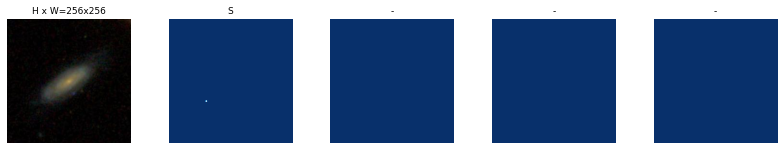

71


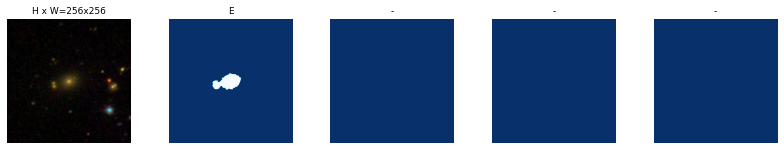

In [34]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 2)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    print(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

### Bounding Boxes



image_id  30 tutorial/train/Dr7_587731872852869458.jpg
image                    shape: (256, 256, 3)         min:    0.00000  max:  253.00000  uint8
mask                     shape: (256, 256, 1)         min:    0.00000  max:    1.00000  bool
class_ids                shape: (1,)                  min:    1.00000  max:    1.00000  int32
bbox                     shape: (1, 4)                min:  109.00000  max:  146.00000  int32


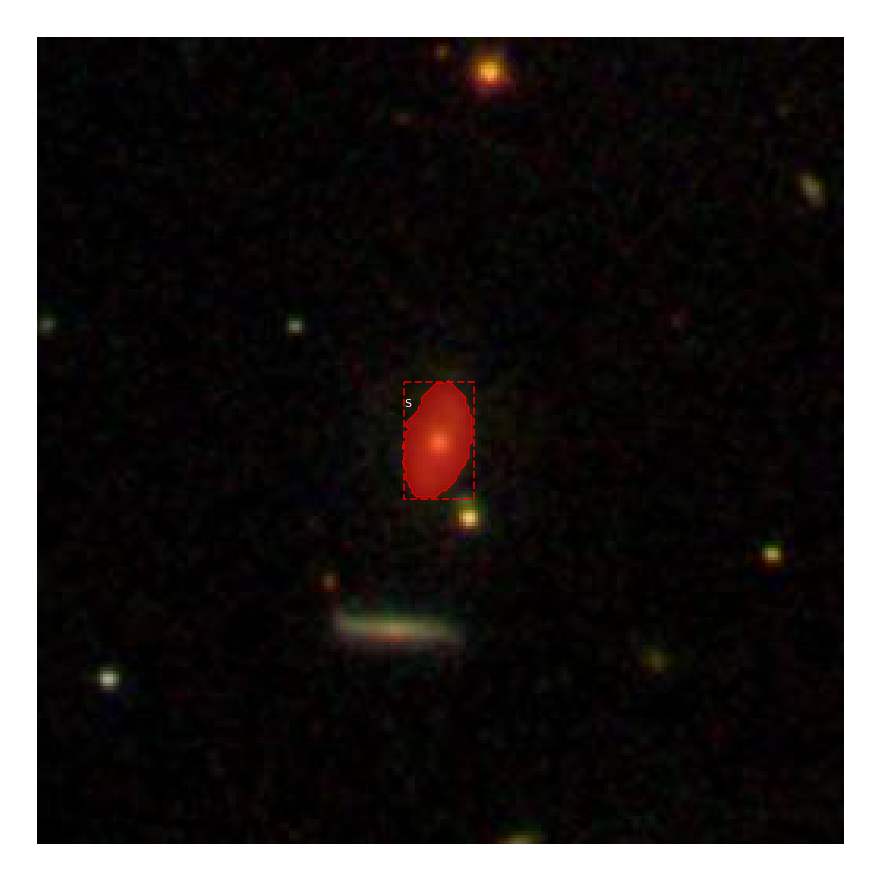

In [35]:
# Load random image and mask.
image_id = 30
image = dataset_train.load_image(image_id)
mask, class_ids = dataset_train.load_mask(image_id)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset_train.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset_train.class_names)

### Mini Masks

Instance binary masks can get large when training with high resolution images. For example, if training with 1024x1024 image then the mask of a single instance requires 1MB of memory (Numpy uses bytes for boolean values). If an image has 100 instances then that's 100MB for the masks alone. 

image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
image_meta               shape: (15,)                 min:    0.00000  max:  256.00000  int64
class_ids                shape: (1,)                  min:    1.00000  max:    1.00000  int32
bbox                     shape: (1, 4)                min:   94.00000  max:  163.00000  int32
mask                     shape: (256, 256, 1)         min:    0.00000  max:    1.00000  bool


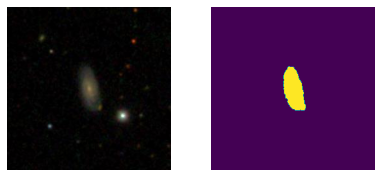

In [36]:
image_id = np.random.choice(dataset_train.image_ids, 1)[0]
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset_train, config, image_id, use_mini_mask=False)

log("image", image)
log("image_meta", image_meta)
log("class_ids", class_ids)
log("bbox", bbox)
log("mask", mask)

display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

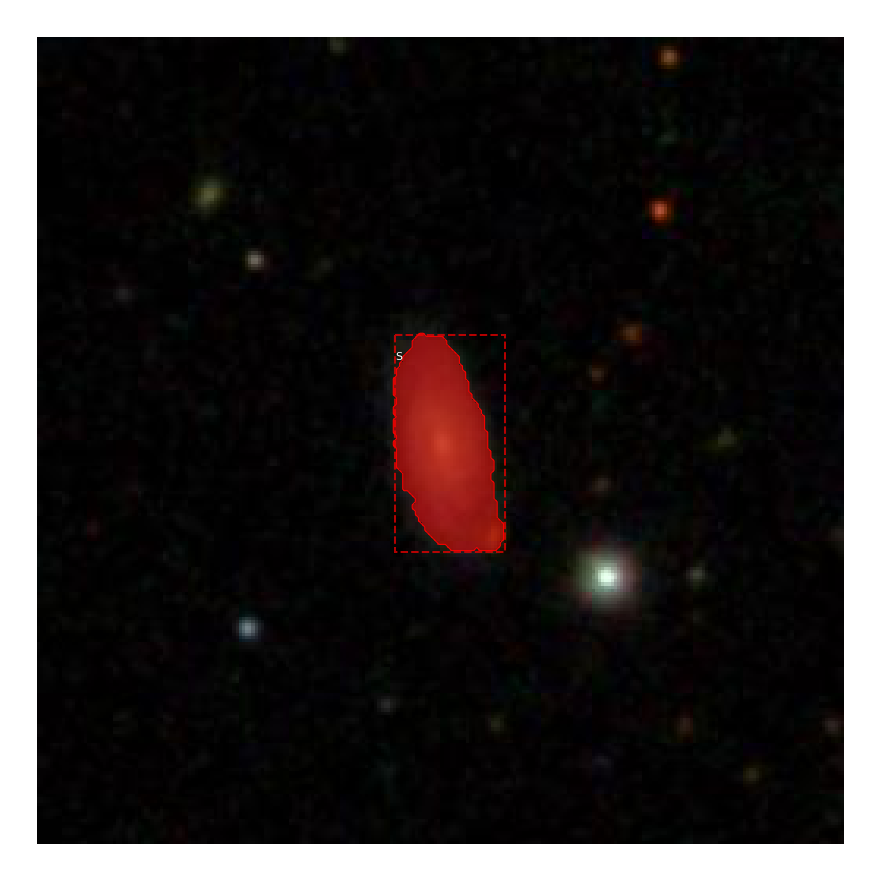

In [37]:
visualize.display_instances(image, bbox, mask, class_ids,  dataset_train.class_names)

mask                     shape: (56, 56, 1)           min:    0.00000  max:    1.00000  bool


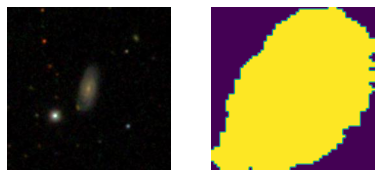

In [38]:
# Add mask resizing.
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset_train, config, image_id, augment=True, use_mini_mask=True)
log("mask", mask)
display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

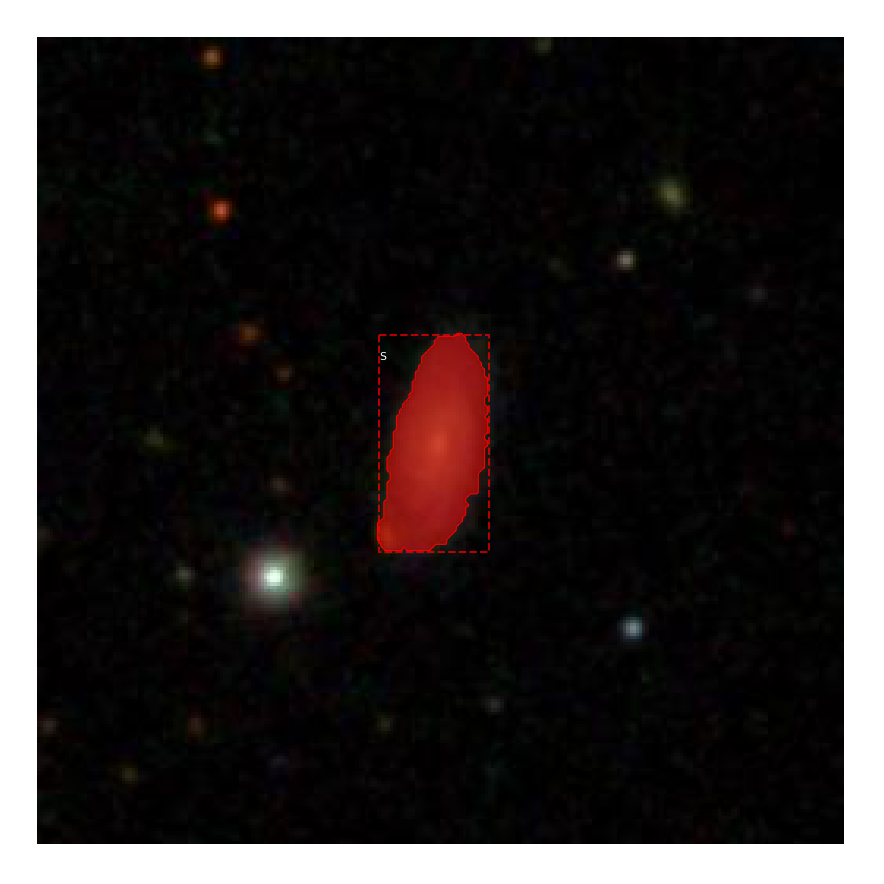

In [39]:
mask = utils.expand_mask(bbox, mask, image.shape)
visualize.display_instances(image, bbox, mask, class_ids, dataset_train.class_names)

# Create Model

In [40]:
dataset_train.class_names

['BG', 'S', 'E']

In [41]:
MODEL_DIR

'ADASS/mrcnn/models'

In [42]:
model = modellib.MaskRCNN(mode="training", config=config,model_dir=MODEL_DIR)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


Instructions for updating:
keep_dims is deprecated, use keepdims instead


Instructions for updating:
keep_dims is deprecated, use keepdims instead


Instructions for updating:
keep_dims is deprecated, use keepdims instead


Instructions for updating:
keep_dims is deprecated, use keepdims instead


Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [43]:
print("Loading weights ", WEIGHTS_PATH)
model.load_weights(WEIGHTS_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])

Loading weights  ADASS/mrcnn/models/galaxia_all.h5


## Data Augmentation

The training and validation datasets are able to satisfy the needs of the problem in terms of volumes and a balanced representation of examples for each class. As indicated, the use of transfer learning based on the backbone of the network and the training strategy also provide a base knowledge to train the model.

But, as it can be seen in Figure, not all augmentation techniques have scientific relevance for the characteristic of astronomical images.

<figure>
<center>
<img src='https://adass2020.s3.amazonaws.com/ejemplos_varios.png' />
<figcaption>Examples of different data augmentation techniques included in the imgaug library and applied to the same image of a spiral galaxy</figcaption></center>
</figure>



In [44]:
from imgaug import augmenters as iaa

In [45]:
seq_of_aug = iaa.SomeOf((0, 4), [
    iaa.Fliplr(0.5),
    iaa.Flipud(0.5),
    iaa.OneOf([iaa.Affine(rotate=90),
               iaa.Affine(rotate=180),
               iaa.Affine(rotate=270)]),
    iaa.AddElementwise((-25, 25))
])

# Training

Train options:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. Simply pass `layers="all` to train all layers.

In [47]:
def train(model, dataset_train,dataset_val,_layers,_learning_rate, epochs):
    """Train the model."""
    print("Training network ="+_layers)
    history = model.train(dataset_train, dataset_val,
                learning_rate=_learning_rate,
                epochs=epochs,
                layers=_layers,
                augmentation=seq_of_aug
                )
    
    return history

In [48]:
_learning_rate=config.LEARNING_RATE
_learning_rate

0.001

In [ ]:
history = train(model, dataset_train,dataset_val,'all',_learning_rate,1 )

Epoch 1/1
 1/10 [==>...........................] - ETA: 2777s - loss: 4.0004 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.1506 - mrcnn_class_loss: 2.3902 - mrcnn_bbox_loss: 0.5204 - mrcnn_mask_loss: 0.93

In [ ]:
model_path = os.path.join(MODEL_DIR, "galaxia_adass.h5")
model.keras_model.save_weights(model_path)

# Detection

In [49]:
%cd

/root


In [50]:
import sys

In [ ]:
ROOT_DIR = "ADASS"
sys.path.insert(1, ROOT_DIR)
sys.path.append(ROOT_DIR)

In [ ]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

  
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

import json
import skimage.draw

In [ ]:
class GalaxiaConfig(Config):
    """Configuration for training on the toy  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "galaxia"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8
    
    
    #BACKBONE = "resnet50"
    
  
    # Adjust down if you use a smaller GPU.
    #IMAGES_PER_GPU = 2

    # Number of classes (including background)
    NUM_CLASSES = 2 + 1  #  Galaxies + Background 

    # Don't exclude based on confidence. Since we have two classes
    DETECTION_MIN_CONFIDENCE = 0.4
    
    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256
    IMAGE_RESIZE_MODE = "crop"

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8,16, 32, 64, 128)  # anchor side in pixels
    
    # How many anchors per image to use for RPN training
    RPN_TRAIN_ANCHORS_PER_IMAGE = 256

    # ROIs kept after non-maximum supression (training and inference)
    POST_NMS_ROIS_TRAINING = 1000
    POST_NMS_ROIS_INFERENCE = 2000

    # Non-max suppression threshold to filter RPN proposals.
    # You can increase this during training to generate more propsals.
    RPN_NMS_THRESHOLD = 0.9

    # Image mean (RGB)
    MEAN_PIXEL = np.array([10.71, 15.81, 19.04])
    
    #BACKBONE_STRIDES  = (8,16, 32, 64, 128)

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 128


    # Maximum number of ground truth instances to use in one image
    MAX_GT_INSTANCES = 200
   
    # Max number of final detections per image
    DETECTION_MAX_INSTANCES = 400

    LEN_TRAIN_ = 200
    LEN_VAL_ = 100
    
    #LEN_TRAIN_ = 24000
    #LEN_VAL_ = 6000


    # Number of training and validation steps per epoch
    #STEPS_PER_EPOCH = max(1, LEN_TRAIN_ // (IMAGES_PER_GPU*GPU_COUNT))
    #VALIDATION_STEPS = max(1,LEN_VAL_ // (IMAGES_PER_GPU*GPU_COUNT))
    
    STEPS_PER_EPOCH = 10
    VALIDATION_STEPS = 20

    #TRAIN_BN = False

    #ACTIVATION = 'relu'

    # Store masks inside the bounding boxes (looses some accuracy but speeds up training)
    USE_MINI_MASK = True

In [ ]:
DATASET_DIR ='tutorial'
DATASET_DIR

In [ ]:
MODEL_DIR = 'ADASS/mrcnn/models'
WEIGHTS_PATH = MODEL_DIR+"/galaxia_all.h5"


In [51]:
class InferenceConfig(GalaxiaConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0.9

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

In [52]:
# Load trained weights
print("Loading weights from ", WEIGHTS_PATH)
model.load_weights(WEIGHTS_PATH, by_name=True)

Loading weights from  ADASS/mrcnn/models/galaxia_all.h5


In [ ]:
class GalaxiaDataset(utils.Dataset):
    
    def load_galaxia(self, dataset_dir, subset):
        """Load a subset of the galaxia dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        #self.add_class("galaxia", 1, "U")
        self.add_class("galaxia", 1, "S")
        self.add_class("galaxia", 2, "E")

        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        annotations = json.load(open(os.path.join(dataset_dir, "via_region_data.json")))
        annotations = list(annotations.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]

        # Add images
        for a in annotations:
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. These are stores in the
            # shape_attributes (see json format above)
            # The if condition is needed to support VIA versions 1.x and 2.x.
            if type(a['regions']) is dict:
                polygons = [r['shape_attributes'] for r in a['regions'].values()]
                objects = [s['region_attributes'] for s in a['regions'].values()]
            else:
                polygons = [r['shape_attributes'] for r in a['regions']]
                objects = [s['region_attributes'] for s in a['regions']]
            
            #class_ids = [n['object_name'] for n in objects]
            
            class_ids = []
            
            for n in objects:
                if(n['object_name'] == "S"):
                    class_ids.append(1)
                if(n['object_name'] == "E"):
                    class_ids.append(2)           

            
            
            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "galaxia",
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons,class_ids=class_ids)

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a galaxia dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "galaxia":
            return super(self.__class__, self).load_mask(image_id)
        
        class_ids = image_info['class_ids']
        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1
        #print("info['class_ids']=", info['class_ids'])
        class_ids = np.array(class_ids, dtype=np.int32)
        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        #return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)
        return mask.astype(np.bool), class_ids

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "galaxia":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "galaxia":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)



In [53]:
%%time
# Validation dataset
dataset_val = GalaxiaDataset()
dataset_val.load_galaxia(DATASET_DIR, "val")
dataset_val.prepare()

CPU times: user 122 ms, sys: 4.77 ms, total: 127 ms
Wall time: 128 ms


### Run Detection

In [54]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [55]:
import datetime

In [56]:
image_id = 1
image = dataset_val.load_image(image_id)

original_image           shape: (256, 256, 3)         min:    0.00000  max:  206.00000  uint8
image_meta               shape: (15,)                 min:    0.00000  max:  256.00000  int64
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:   86.00000  max:  173.00000  int32
gt_mask                  shape: (256, 256, 1)         min:    0.00000  max:    1.00000  bool


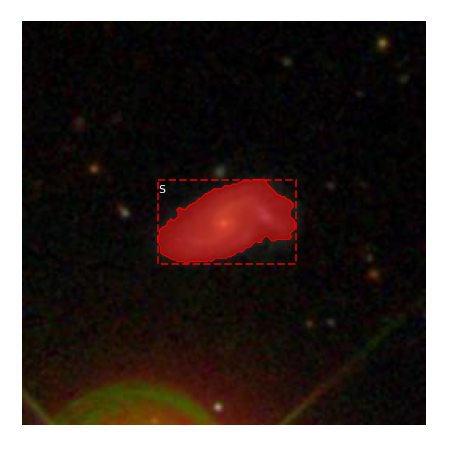

In [57]:
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_val.class_names, figsize=(8, 8))

In [58]:
class_names = ['BG',"E","S"]

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  206.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min:  -19.04000  max:  195.29000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32


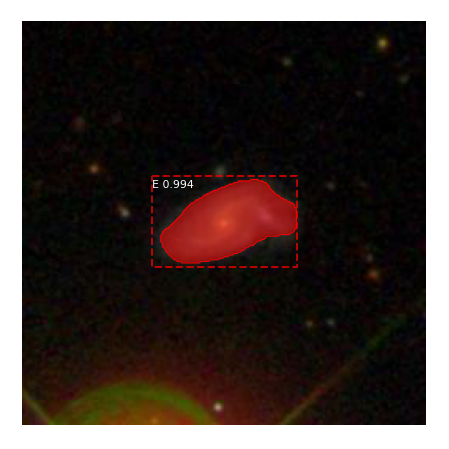

In [59]:
# Run detection
results = model.detect([image], verbose=1)
# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'], ax=get_ax())

In [60]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.9


# References

- https://github.com/matterport/Mask_RCNN